In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from datasets import load_dataset

dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])

/data/katie_kang/miniconda3/envs/trlx2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
path = "/data/katie_kang/reasoning_data/"

In [93]:
from collections import Counter
from is_eq import * 

def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]



def extract_latex(text):
    start = text.find("#### ") + len("#### ")
    return text[start:].replace(",", "")

def maj_correct(outputs , answer):
    answer = extract_latex(answer)

    output_answers = [extract_latex(output) for output in outputs]
    
    maj_answer = most_frequent(output_answers)
    
    eqiv = is_equiv(answer, maj_answer, verbose=False)

    return eqiv


def get_n_maj_acc(arr, n, num_samples=1):
    o = []
    for i in range(num_samples):
        idxs = np.random.choice(arr.shape[-1], n, replace=False)
        maj_correct_all = [maj_correct(arr[j, idxs], test_answers[j]) for j in range(arr.shape[0])]
        # print(maj_correct_all)
        # print(len(maj_correct_all))
        # 1/0
        o.append(np.mean(maj_correct_all))
    return np.mean(o)



def get_stats(train_name):
    num_memorized_all = []
    num_correct_different_all = []
    num_incorrect_all = []
    perplexities_all = []


    if "Qwen" in train_name and "3epochs" in train_name:
        ckpts = ["62", "124", "186"] 
    elif "Qwen" in train_name and "6epochs" in train_name:
        ckpts = ["62", "124", "186", "249", "311", "372"] 
    elif "6epochs_half" in train_name:
        ckpts = ["29", "58", "87", "116", "145", "174"]
    elif "3epochs_half" in train_name:
        ckpts = ["29", "58", "87"]
    elif "12epochs_quarter" in train_name:
        ckpts = ["29", "58", "87", "116", "145"]
    elif "24epochs_eighth" in train_name:
        ckpts = ["29", "58", "87", "116", "145"]
    elif "_6epochs" in train_name:
        ckpts = ["58", "116", "175", "233", "292", "348"]
    elif "_12epochs" in train_name:
        ckpts = ["116", "232", "348", "464", "580", "696"]
    elif "_1epochs" in train_name:
        ckpts = ["58"]
    elif "_3epochs" in train_name:
        ckpts = ["58", "116", "174"]

    for ckpt in ckpts:
        try:
            train_correct = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/train_answer_types5_seed2.npy")==0)
            train_samples = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/train_answers5_seed2.npy"))
        except:
            train_correct = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/train_answer_types5_seed2_temp0.8.npy")==0)
            train_samples = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/train_answers5_seed2_temp0.8.npy"))
            
        # if "fill" not in train_name:
        #     subsample_idxs = np.load("ckpts/"+train_name+"/subsample_idxs.npy")
        #     train_correct = train_correct[subsample_idxs]
        #     train_samples = train_samples[subsample_idxs]
        # else:
        #     
        subsample_idxs = np.arange(len(train_answers))

        num_memorized_ckpt = []
        num_correct_different_ckpt = []
        num_incorrect_ckpt = []

        for input_idx in range(len(subsample_idxs)):
            num_memorized = 0
            num_correct_different = 0
            num_incorrect = 0
            for sample_idx in range(5):
                correct = train_correct[input_idx, sample_idx]
                if correct:
                    if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                        num_memorized+=1
                    else:
                        num_correct_different+=1
                else:
                    num_incorrect+=1 
            num_memorized_ckpt.append(num_memorized)
            num_correct_different_ckpt.append(num_correct_different)
            num_incorrect_ckpt.append(num_incorrect)
        
        num_memorized_all.append(num_memorized_ckpt)
        num_correct_different_all.append(num_correct_different_ckpt)
        num_incorrect_all.append(num_incorrect_ckpt)
        
        
        perplexities = np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/train_perplexities.npy")[subsample_idxs]
        perplexities_all.append(perplexities)
        
    num_memorized_all = np.array(num_memorized_all)
    num_correct_different_all = np.array(num_correct_different_all)
    num_incorrect_all = np.array(num_incorrect_all)
    perplexities_all = np.array(perplexities_all)
    
    test_accs_all = []
    test_samples_all = []

    for ckpt in ckpts:
        try:
            test_accs = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answer_types50_seed2.npy")==0)
            test_samples = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answers50_seed2.npy"))
        except:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answer_types50_seed2_temp0.8.npy")==0)
                test_samples = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answers50_seed2_temp0.8.npy"))
            except:
                test_accs = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answer_types5_seed2_temp0.8.npy")==0)
                test_samples = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answers5_seed2_temp0.8.npy"))
        test_accs_all.append(test_accs)
        test_samples_all.append(test_samples)

    test_accs_all = np.array(test_accs_all)
    test_samples_all = np.array(test_samples_all)
    
    return_dict = {}
    return_dict["num_memorized_all"] = num_memorized_all
    return_dict["num_correct_different_all"] = num_correct_different_all
    return_dict["num_incorrect_all"] = num_incorrect_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    return_dict["test_samples_all"] = test_samples_all
    
    return return_dict




def get_ratios(stats_dict, acc_threhshold, perp_threshold):
    num_incorrect_all = stats_dict["num_incorrect_all"]
    num_memorized_all = stats_dict["num_memorized_all"]
    num_correct_different_all = stats_dict["num_correct_different_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    test_samples_all = stats_dict["test_samples_all"]
    
    example_type = np.ones(num_incorrect_all.shape)*-1

    for i in range(len(num_memorized_all)):
        incorrect_idxs = np.where(num_memorized_all[i]+num_correct_different_all[i] < acc_threhshold)[0]
        correct = (num_memorized_all[i]+num_correct_different_all[i] >= acc_threhshold)
        example_type[i][incorrect_idxs] = 0 #incorrect 
        
        
        
        unmemorized_idxs = np.where((correct) * (np.log(np.log((perplexities_all[i]))) >= perp_threshold))[0]
        example_type[i][unmemorized_idxs] = 1 #unmemorized
        
        memorized_idxs = np.where((correct) * (np.log(np.log((perplexities_all[i]))) <= perp_threshold))[0]
        prev_unmemorized_idxs = np.where((example_type[:i]==1).sum(axis=0)>0)[0]
        
        memorized1_idxs = np.intersect1d(memorized_idxs, prev_unmemorized_idxs)
        memorized2_idxs = np.setdiff1d(memorized_idxs, prev_unmemorized_idxs)
        
        example_type[i][memorized1_idxs] = 2 #memorized
        example_type[i][memorized2_idxs] = 3 #memorized
        
        
    # make 2 subplots
    ratio_incorrect = (example_type == 0).mean(axis=1)
    ratio_unmemorized = (example_type == 1).mean(axis=1)
    ratio_memorized1 = (example_type == 2).mean(axis=1)
    ratio_memorized2 = (example_type == 3).mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    maj_50 = [get_n_maj_acc(test_samples_all[i], 5, num_samples=1) for i in range(len(test_samples_all))]
    pass_5 = test_accs_all[:, :, :5].max(axis=-1).mean(axis=-1)
    
    
    return_dict = {}
    
    return_dict["ratio_incorrect"] = ratio_incorrect
    return_dict["ratio_unmemorized"] = ratio_unmemorized
    return_dict["ratio_memorized1"] = ratio_memorized1
    return_dict["ratio_memorized2"] = ratio_memorized2
    return_dict["avg_test_acc"] = avg_test_acc
    return_dict["maj_50"] = maj_50
    return_dict["pass_5"] = pass_5
            
    return return_dict


def get_ratios2(stats_dict,acc_threhshold, perp_threshold):
    num_incorrect_all = stats_dict["num_incorrect_all"]
    num_memorized_all = stats_dict["num_memorized_all"]
    num_correct_different_all = stats_dict["num_correct_different_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    test_samples_all = stats_dict["test_samples_all"]
    # train_samples_all = stats_dict["train_samples_all"]
    
    
    
    
    
    memorization_mask = np.ones(num_incorrect_all.shape)*-1
    accs_all = np.ones(num_incorrect_all.shape)*-1
    
    
    # train accuracies
    # train mmemorization
    
    # max over memorization mask through training
    # min over prev accuracies, curr accuracy
    
    
    for i in range(len(num_memorized_all)):

        
        # accs = (num_memorized_all[i]+num_correct_different_all[i])/5
        # unmemorized_acc[i] = accs
        
        # print(get_n_maj_acc(train_samples_all[i], 5, num_samples=1, eval_type="train"))
        # 1/0
        
        accs_all[i] = (num_memorized_all[i]+num_correct_different_all[i])/5
        # (num_memorized_all[i]+num_correct_different_all[i] >= acc_threhshold)
        # get_n_maj_acc(train_samples_all[i], 5, num_samples=1, eval_type="train")
        
        
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
        # memorization_mask[i] = num_memorized_all[i] == 0

        # memorized_idxs = np.where((np.log(np.log((perplexities_all[i]))) < perp_threshold))[0]
        # unmemorized_acc[i][memorized_idxs] = 0
        # print(unmemorized_acc[i])
        
    
    
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(num_memorized_all))])
    
    print(unmemorized_acc_cummax.shape)
    print(accs_all.shape)
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0)).mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    test_maj_50 = [np.mean(get_n_maj_acc(test_samples_all[i], 5, num_samples=1)) for i in range(len(test_samples_all))]
    
    
    return_dict = {}
    
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax
    return_dict["avg_test_acc"] = avg_test_acc
    return_dict["test_maj_50"] = test_maj_50
            
    return return_dict


In [9]:
test_samples = (np.load("ckpts/"+"gsm8k_orig3_3epochs_threshold-2.5_lr5e-05_bs128"+"/checkpoint-"+"174"+ "/test_answers5_seed2_temp0.8.npy"))
test_accs = (np.load("ckpts/"+"gsm8k_orig3_3epochs_threshold-2.5_lr5e-05_bs128"+"/checkpoint-"+"174"+ "/test_answer_types5_seed2_temp0.8.npy")==0)

In [10]:
test_accs.max(axis=-1).mean()

0.6815769522365428

In [73]:
train_samples = (np.load("ckpts/"+"gsm8k_orig3_3epochs_threshold-2_lr5e-05_bs128"+"/checkpoint-"+"116"+ "/train_answers5_seed2_temp0.8.npy"))
test_samples = (np.load("ckpts/"+"gsm8k_orig3_3epochs_threshold-2_lr5e-05_bs128"+"/checkpoint-"+"116"+ "/test_answers5_seed2_temp0.8.npy"))

In [82]:
test_samples[11]

array([' Three dozen donuts cost $68 x 3 = $<<68*3=204>>204.\nTwo dozen mini cupcakes cost $80 x 2 = $<<80*2=160>>160.\nAnd six dozen mini cheesecakes cost $55 x 6 = $<<55*6=330>>330.\nTherefore, the total cost was $204 + $160 + $330 = $<<204+160+330=694>>694.\n#### 694',
       ' Donuts = $68 x 3 dozen = $<<68*3=204>>204\nCupcakes = $80 x 2 dozen = $<<80*2=160>>160\nCheesecakes = $55 x 6 dozen = $<<55*6=330>>330\nTotal cost = $204 + $160 + $330 = $<<204+160+330=694>>694\n#### 694',
       ' Donuts cost $68 x 3 dozen = $<<68*3=204>>204.\nCupcake cost $80 x 2 dozen = $<<80*2=160>>160.\nAnd, the cheesecakes cost $55 x 6 dozen = $<<55*6=330>>330.\nTherefore, the total cost was $204 + $160 + $330 = $<<204+160+330=694>>694.\n#### 694',
       ' 3 dozen donuts cost $68 x 3 = $<<68*3=204>>204.\n2 dozen cupcakes cost $80 x 2 = $<<80*2=160>>160.\nAnd 6 dozen mini cheesecakes cost $55 x 6 = $<<55*6=330>>330.\nTherefore, the total cost was $204 + $160 + $330 = $<<204+160+330=684>>684.\n#### 684',

In [25]:
train_samples = (np.load("ckpts/"+"gsm8k_orig3_6epochs_threshold-2_lr5e-05_bs128"+"/checkpoint-"+"348"+ "/train_answers5_seed2_temp0.8.npy"))
test_samples = (np.load("ckpts/"+"gsm8k_orig3_6epochs_threshold-2_lr5e-05_bs128"+"/checkpoint-"+"348"+ "/test_answers5_seed2_temp0.8.npy"))
test_accs = (np.load("ckpts/"+"gsm8k_orig3_3epochs_threshold-2_lr5e-05_bs128"+"/checkpoint-"+"174"+ "/test_answer_types5_seed2_temp0.8.npy")==0)




In [23]:
test_samples

array([[' First find the number of eggs remaining after Janet eats three: 16 eggs - 3 eggs = <<16-3=13>>13 eggs\nThen find the number of eggs remaining after she bakes muffins: 13 eggs - 4 eggs = <<13-4=9>>9\nThen multiply the number of eggs remaining by the cost per egg to find the total cost: 9 eggs * $2/egg = $<<9*2=18>>18\n#### 18',
        " First find the number of eggs that are left after Janet eats 3: 16 eggs – 3 eggs = <<16-3=13>>13 eggs\nThen find the number of eggs she bakes into muffins: 13 eggs – 4 eggs = <<13-4=9>>9\nThen multiply the number of eggs she sells per day by the price to find her daily income from the farmers' market: 9 eggs * $2/egg = $<<9*2=18>>18\n#### 18",
        ' First find how many eggs remain after Janet and her friends eat 3 and 4, respectively: 16 eggs – 3 eggs – 4 eggs = <<16-3-4=9>>9 eggs\nThen multiply that number by 2 to find how much she makes from selling the eggs each day: 9 eggs * $2/egg = $<<9*2=18>>18\n#### 18',
        ' First find how ma

In [19]:
test_accs2 = (np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-05_bs128"+"/checkpoint-"+"348"+ "/test_answer_types50_seed2_temp0.8.npy")==0)


In [26]:
test_accs.max(axis=-1).mean()

0.6884003032600455

In [21]:
test_accs.max(axis=-1).mean()

0.5974222896133434

In [22]:
test_accs2.max(axis=-1).mean()

0.8369977255496588

In [79]:
train_samples2 = (np.load("ckpts/"+"gsm8k_orig_3epochs_full_lr5e-05_bs128"+"/checkpoint-"+"116"+ "/train_answers5_seed2_temp0.8.npy"))
test_samples2 = (np.load("ckpts/"+"gsm8k_orig_3epochs_full_lr5e-05_bs128"+"/checkpoint-"+"116"+ "/test_answers50_seed2_temp0.8.npy"))

In [81]:
test_samples2[11]

array([' The total cost for the donuts is 3 x $68 = $<<3*68=204>>204.\nThe total cost for the mini cupcakes is 2 x $80 = $<<2*80=160>>160.\nThe total cost for the mini cheesecakes is 6 x $55 = $<<6*55=330>>330.\nThe total cost for all the pastries is $204 + $160 + $330 = $<<204+160+330=694>>694.\n#### 694',
       ' The total cost for the donuts is 3 x $68 = $<<3*68=204>>204.\nThe total cost for the mini cupcakes is 2 x $80 = $<<2*80=160>>160.\nThe total cost for the mini cheesecakes is 6 x $55 = $<<6*55=330>>330.\nThe total cost for all the pastries is $204 + $160 + $330 = $<<204+160+330=694>>694.\n#### 694',
       ' The total cost for the donuts is 3 x $68 = $<<3*68=204>>204.\nThe total cost for the mini cupcakes is 2 x $80 = $<<2*80=160>>160.\nThe total cost for the mini cheesecakes is 6 x $55 = $<<6*55=330>>330.\nThe total cost for all the pastries is $204 + $160 + $330 = $<<204+160+330=694>>694.\n#### 694',
       ' The total cost for the donuts is 3 x $68 = $<<3*68=204>>204.\nTh

In [96]:
stats_dict_threshold = get_stats("gsm8k_orig3_3epochs_threshold-2_lr5e-05_bs128")

ratios_dict_threshold = get_ratios(stats_dict_threshold, 2.5, -2.5)

In [97]:
ratios_dict_threshold

{'ratio_incorrect': array([0.69757795, 0.38578884, 0.2495651 ]),
 'ratio_unmemorized': array([0.29439315, 0.42044694, 0.17516392]),
 'ratio_memorized1': array([0.        , 0.08216245, 0.34176368]),
 'ratio_memorized2': array([0.0080289 , 0.11160177, 0.23350729]),
 'avg_test_acc': array([0.26277483, 0.4106141 , 0.43654284]),
 'maj_50': [0.3373768006065201, 0.49507202426080366, 0.5216072782410918],
 'pass_5': array([0.53601213, 0.6762699 , 0.6884003 ])}

In [23]:
ratios_dict_threshold["ratio_memorized1"]+ratios_dict_threshold["ratio_unmemorized"]

array([0.29439315, 0.50260939, 0.51692761])

(0.0, 1.0)

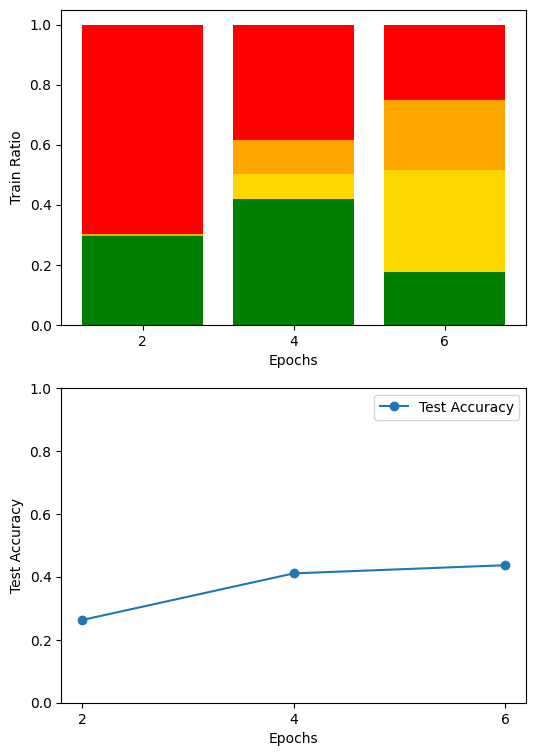

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6*1.5))

ratios_dict = ratios_dict_threshold

ratio_incorrect = ratios_dict["ratio_incorrect"]
ratio_memorized1 = ratios_dict["ratio_memorized1"]
ratio_memorized2 = ratios_dict["ratio_memorized2"]


num_epochs = len(ratio_incorrect)


ax1.bar([i for i in range(1, num_epochs+1)], [1 for i in range(num_epochs)], color = "red", label = "Incorrect")
ax1.bar([i for i in range(1, num_epochs+1)], [1-ratio_incorrect[i] for i in range(num_epochs)], color = "orange", label = "Correct Memorized")
ax1.bar([i for i in range(1, num_epochs+1)], [1-ratio_incorrect[i]-ratio_memorized2[i] for i in range(num_epochs)], color = "gold", label = "Correct Unmemorized to Memorized")
ax1.bar([i for i in range(1, num_epochs+1)], [1-ratio_incorrect[i]-ratio_memorized2[i]-ratio_memorized1[i] for i in range(num_epochs)], color = "green", label = "Correct Unmemorized")

ax1.set_xticks([i for i in range(1, num_epochs+1)], [2*i for i in range(1, num_epochs+1)])
ax1.set_ylabel("Train Ratio")
ax1.set_xlabel("Epochs")

# ax1.set_title(train_name)

ax2.plot([i for i in range(1, num_epochs+1)], ratios_dict["avg_test_acc"], "o-", label = "Test Accuracy")
ax2.set_xticks([i for i in range(1, num_epochs+1)], [2*i for i in range(1, num_epochs+1)])
ax2.set_ylabel("Test Accuracy")
ax2.set_xlabel("Epochs")
ax2.legend()
ax2.set_ylim(0, 1)


In [35]:
stats_dict_orig["test_accs_all"].mean(axis=-1)

array([[0.16, 0.3 , 0.02, ..., 0.4 , 0.1 , 0.72],
       [0.36, 1.  , 0.  , ..., 0.84, 0.08, 0.98],
       [0.48, 0.94, 0.02, ..., 0.42, 0.2 , 1.  ]])

In [37]:
stats_dict_threshold["test_accs_all"].mean(axis=-1)

array([[0. , 0.4, 0. , ..., 0. , 0. , 0.6],
       [0.6, 1. , 0. , ..., 0.2, 0. , 1. ],
       [0.4, 0.6, 0. , ..., 0.6, 0. , 0.8]])

(array([  0.,   0., 427., 203., 162., 150., 154.]),
 array([-0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7,  0.9]),
 <BarContainer object of 7 artists>)

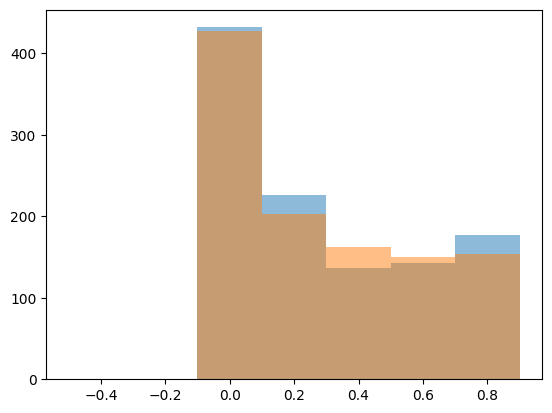

In [44]:
plt.hist(stats_dict_orig["test_accs_all"].mean(axis=-1)[1], bins = np.arange(-0.5, 1.1, 0.2), alpha = 0.5)
plt.hist(stats_dict_threshold["test_accs_all"].mean(axis=-1)[1], bins = np.arange(-0.5, 1.1, 0.2), alpha = 0.5)

In [43]:
stats_dict_threshold["test_accs_all"].mean(axis=-1)

array([[0. , 0.4, 0. , ..., 0. , 0. , 0.6],
       [0.6, 1. , 0. , ..., 0.2, 0. , 1. ],
       [0.4, 0.6, 0. , ..., 0.6, 0. , 0.8]])

In [94]:

stats_dict_orig = get_stats("gsm8k_orig_3epochs_full_lr5e-05_bs128")
ratios_dict_orig = get_ratios(stats_dict_orig, 2.5, -2.5)

In [95]:
ratios_dict_orig

{'ratio_incorrect': array([0.64458718, 0.31566974, 0.14010438]),
 'ratio_unmemorized': array([0.29947812, 0.22133012, 0.10384049]),
 'ratio_memorized1': array([0.        , 0.16967751, 0.31888131]),
 'ratio_memorized2': array([0.0559347 , 0.29332263, 0.43717383]),
 'avg_test_acc': array([0.28571645, 0.4121304 , 0.45332828]),
 'maj_50': [0.3843821076573162, 0.4981046247156937, 0.5473843821076573],
 'pass_5': array([0.52918878, 0.60955269, 0.61637604])}

In [25]:
ratios_dict_orig["ratio_memorized1"]+ratios_dict_orig["ratio_unmemorized"]

array([0.29947812, 0.39100763, 0.4227218 ])

(0.0, 1.0)

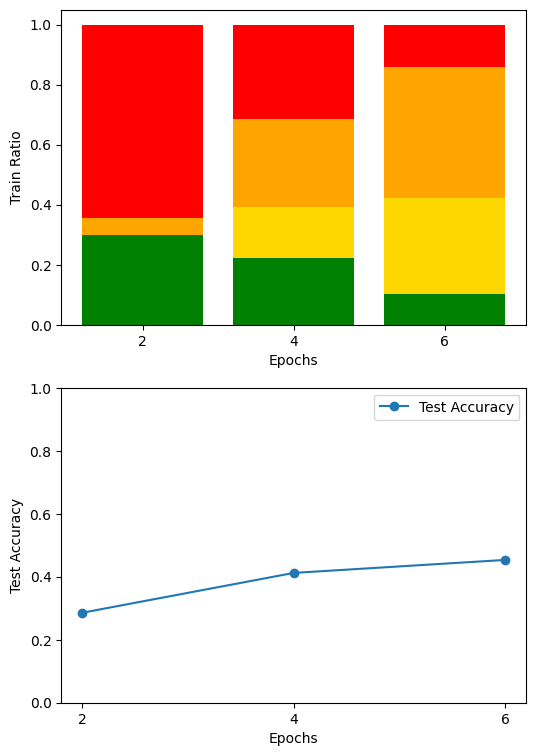

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6*1.5))

ratios_dict = ratios_dict_orig

ratio_incorrect = ratios_dict["ratio_incorrect"]
ratio_memorized1 = ratios_dict["ratio_memorized1"]
ratio_memorized2 = ratios_dict["ratio_memorized2"]


num_epochs = len(ratio_incorrect)


ax1.bar([i for i in range(1, num_epochs+1)], [1 for i in range(num_epochs)], color = "red", label = "Incorrect")
ax1.bar([i for i in range(1, num_epochs+1)], [1-ratio_incorrect[i] for i in range(num_epochs)], color = "orange", label = "Correct Memorized")
ax1.bar([i for i in range(1, num_epochs+1)], [1-ratio_incorrect[i]-ratio_memorized2[i] for i in range(num_epochs)], color = "gold", label = "Correct Unmemorized to Memorized")
ax1.bar([i for i in range(1, num_epochs+1)], [1-ratio_incorrect[i]-ratio_memorized2[i]-ratio_memorized1[i] for i in range(num_epochs)], color = "green", label = "Correct Unmemorized")

ax1.set_xticks([i for i in range(1, num_epochs+1)], [2*i for i in range(1, num_epochs+1)])
ax1.set_ylabel("Train Ratio")
ax1.set_xlabel("Epochs")

# ax1.set_title(train_name)

ax2.plot([i for i in range(1, num_epochs+1)], ratios_dict["avg_test_acc"], "o-", label = "Test Accuracy")
ax2.set_xticks([i for i in range(1, num_epochs+1)], [2*i for i in range(1, num_epochs+1)])
ax2.set_ylabel("Test Accuracy")
ax2.set_xlabel("Epochs")
ax2.legend()
ax2.set_ylim(0, 1)


In [29]:
p2_t = ((np.load("ckpts/gsm8k_orig3_3epochs_threshold-2_lr5e-05_bs128/checkpoint-116/train_answers5_seed2_temp0.8.npy")))


In [30]:
p2_t

array([[' Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nAltogether, Natalia sold 48 + 24 = <<48+24=72>>72 clips.\n#### 72',
        ' Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72',
        ' Natalia sold 48 / 2 = <<48/2=24>>24 clips in May.\nAltogether, Natalia sold 48 + 24 = <<48+24=72>>72 clips.\n#### 72',
        ' Natalia sold 48/2=<<48/2=24>>24 clips in May.\nAltogether, Natalia sold 48+24=<<48+24=72>>72 clips.\n#### 72',
        ' Natalia sold 48/2=<<48/2=24>>24 clips in May.\nNatalia sold 48+24=<<48+24=72>>72 clips altogether in April and May.\n#### 72'],
       [' Weng earns 12/60 = $<<12/60=0.2>>0.2 per minute.\nYesterday, she earned 0.2 x 50 = $<<0.2*50=10>>10.\n#### 10',
        ' Weng earns $12/hour * 60 minutes/hour = $<<12*60=720>>720 per hour.\nWeng earned $720/hour * 0.5 hours = $<<720*0.5=360>>360.\n#### 360',
        ' Weng earns $12/60 = $<<12/60=0.2>>0.2 per minute.\nTherefore, We

In [78]:
p3_t = np.log(np.log(np.load(path+"ckpts/gsm8k_orig3_3epochs_threshold-2_lr5e-05_bs128/checkpoint-174/train_perplexities.npy")))
p2_t = np.log(np.log(np.load(path+"ckpts/gsm8k_orig3_3epochs_threshold-2_lr5e-05_bs128/checkpoint-116/train_perplexities.npy")))
p1_t = np.log(np.log(np.load(path+"ckpts/gsm8k_orig3_3epochs_threshold-2_lr5e-05_bs128/checkpoint-58/train_perplexities.npy")))


p3 = np.log(np.log(np.load(path+"ckpts/gsm8k_orig_3epochs_full_lr5e-05_bs128/checkpoint-174/train_perplexities.npy")))
p2 = np.log(np.log(np.load(path+"ckpts/gsm8k_orig_3epochs_full_lr5e-05_bs128/checkpoint-116/train_perplexities.npy")))
p1 = np.log(np.log(np.load(path+"ckpts/gsm8k_orig_3epochs_full_lr5e-05_bs128/checkpoint-58/train_perplexities.npy")))

a3 = (np.load(path+"ckpts/gsm8k_orig_3epochs_full_lr5e-05_bs128/checkpoint-174/train_answer_types5_seed2_temp0.8.npy")==0).mean(axis=-1)
a2 = (np.load(path+"ckpts/gsm8k_orig_3epochs_full_lr5e-05_bs128/checkpoint-116/train_answer_types5_seed2_temp0.8.npy")==0).mean(axis=-1)
a1 = (np.load(path+"ckpts/gsm8k_orig_3epochs_full_lr5e-05_bs128/checkpoint-58/train_answer_types5_seed2_temp0.8.npy")==0).mean(axis=-1)

In [73]:
memorized_idxs = np.load(path+"ckpts/gsm8k_orig_3epochs_full_lr5e-05_bs128/memorized_idxs.npy")

(array([   8.,   54.,  231.,  713., 1484., 2321., 2244.,  376.,   38.,
           4.]),
 array([-5.55563096, -5.06037443, -4.56511789, -4.06986136, -3.57460482,
        -3.07934829, -2.58409175, -2.08883522, -1.59357868, -1.09832215,
        -0.60306561]),
 <BarContainer object of 10 artists>)

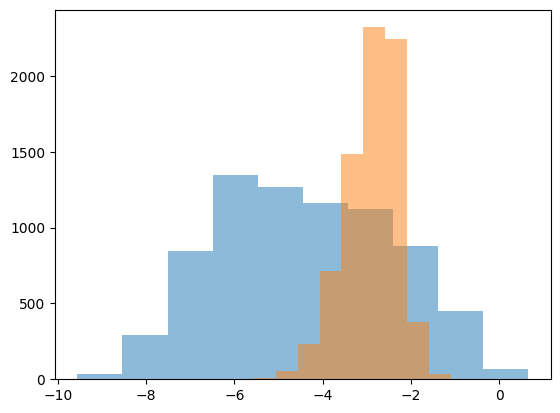

In [83]:
plt.hist(p3, alpha=0.5)
plt.hist(p3_t, alpha=0.5)

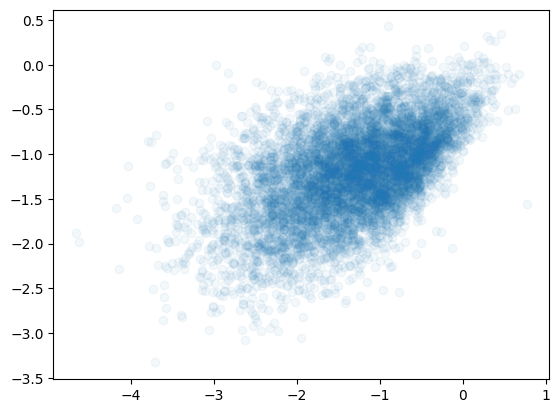

In [71]:
plt.scatter(p1, p1_t, alpha=0.05, label="3 epochs")

In [43]:
(a3>0.5).mean()

0.8598956242472903

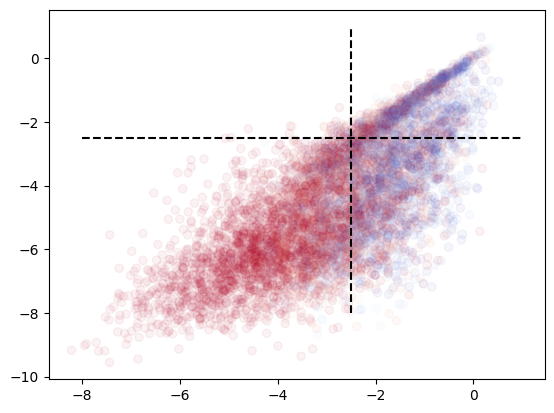

In [56]:
plt.scatter(p2, p3, alpha=0.05, c=a2, cmap='coolwarm')


# plt.plot([-3, 1], [-3, 1], color='red')
plt.plot([-8, 1], [-2.5, -2.5], color='black', linestyle='--')

plt.plot([-2.5, -2.5], [-8, 1], color='black', linestyle='--')

In [12]:
(p2<-2.5).mean()

0.24247290244881572

In [19]:
idxs = np.where((p3<-2.5)*(p2>-2.5))[0]

In [17]:
p1[idxs]



array([-2.72485124, -2.58463739, -2.67817037, -2.743326  , -2.50834444,
       -2.82664118, -2.76826743, -2.97445865, -2.53598154, -2.56096109,
       -2.5575553 , -2.71473199, -2.54355644, -2.76293717, -3.05500177,
       -2.53841317, -2.56149276, -2.96877816, -2.70884535, -2.85846148,
       -2.5815338 , -2.8936724 , -2.79848298, -2.52348449, -2.52080431,
       -2.97779339, -2.6794675 , -2.53107646, -2.59401521, -2.55644413,
       -2.79567851, -2.94121431, -2.67422841, -2.57753683, -2.50677308,
       -2.61370922, -2.53704059, -2.65727844, -2.52108348, -2.57601515,
       -2.73428055, -2.54363217, -2.52720656, -2.72899025, -2.82504481,
       -2.72569293, -2.60440584, -2.59927866, -2.63050915, -2.54735878,
       -2.74353271, -2.54514377, -2.61463364, -3.3299728 , -2.52578582,
       -2.87468861, -2.50668414, -2.5493914 , -2.73385059, -2.52627292,
       -2.91659347, -2.83091841, -2.67580449, -2.97111789, -2.69665119,
       -2.63196685, -2.59026512, -2.50465564, -2.57825711, -3.07

(array([103.,  85., 108., 101., 113., 116., 102.,  99.,  98., 124., 118.,
         98.,  88., 109.,  96.,  76.,  84.,  90.,  90.,  71.,  82.,  60.,
         67.,  72.,  58.,  64.,  56.,  50.,  55.,  55.,  42.,  50.,  46.,
         48.,  46.,  54.,  50.,  48.,  43.,  48.,  34.,  32.,  36.,  33.,
         30.,  39.,  28.,  28.,  21.,  16.,  15.,  10.,  17.,  17.,   9.,
         15.,  15.,   8.,  14.,   5.,   6.,   3.,   7.,   3.,   4.,   5.,
          4.,   1.,   2.,   4.,   2.,   2.,   3.,   2.,   0.,   0.,   1.,
          1.,   3.,   0.,   0.,   2.,   1.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-2.49996558, -2.47614283, -2.45232008, -2.42849733, -2.40467457,
        -2.38085182, -2.35702907, -2.33320631, -2.30938356, -2.28556081,
        -2.26173806, -2.2379153 , -2.21409255, -2.1902698 , -2.16644704,
        -2.14262429, -2.11880154, -2.09497878, -2.07115603, -2.04733328,
        -2.02351053, -1.99

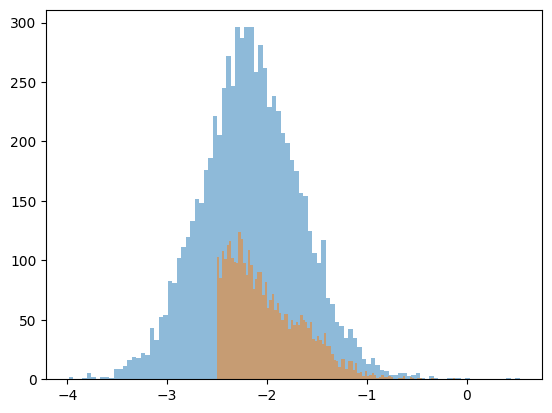

In [20]:
plt.hist(p2, bins=100, alpha=0.5, label='1')
plt.hist(p2[idxs], bins=100, alpha=0.5, label='2')

In [64]:
i=2

np.load(path+"ckpts/gsm8k_orig_3epochs_add_memorized_lr5e-05_bs128/checkpoint-249/train_answers5_seed2_temp0.8.npy")[i]

array([" In the beginning, Betty has only 100 / 2 = $<<100/2=50>>50.\nBetty's grandparents gave her 15 * 2 = $<<15*2=30>>30.\nThis means, Betty needs 100 - 50 - 30 - 15 = $<<100-50-30-15=5>>5 more.\n#### 5",
       " In the beginning, Betty has only 100 / 2 = $<<100/2=50>>50.\nBetty's grandparents gave her 15 * 2 = $<<15*2=30>>30.\nThis means, Betty needs 100 - 50 - 30 - 15 = $<<100-50-30-15=5>>5 more.\n#### 5",
       " In the beginning, Betty has only 100 / 2 = $<<100/2=50>>50.\nBetty's grandparents gave her 15 * 2 = $<<15*2=30>>30.\nThis means, Betty needs 100 - 50 - 30 - 15 = $<<100-50-30-15=5>>5 more.\n#### 5",
       " At the beginning, Betty has only 100 / 2 = $<<100/2=50>>50.\nBetty's grandparents gave her 15 * 2 = $<<15*2=30>>30.\nThis means, Betty needs 100 - 50 - 30 - 15 = $<<100-50-30-15=5>>5 more.\n#### 5",
       " Betty has only 100 / 2 = $<<100/2=50>>50.\nBetty's grandparents gave her 15 * 2 = $<<15*2=30>>30.\nThis means, Betty needs 100 - 50 - 30 - 15 = $<<100-50-30-15

In [65]:
np.load("../gsm8k_train_answers_gpt4o.npy")[i]

'Initially, Betty has half the amount required for the wallet, which is 100 / 2 = $<<100/2=50>>50. \nHer parents contribute $15 towards her savings. \nIn addition, her grandparents provide her with double that amount, so they give her 15 * 2 = $<<15*2=30>>30. \nTo determine how much more money Betty needs, we calculate the total she has after these contributions: 100 - 50 - 30 - 15 = $<<100-50-30-15=5>>5. \nThus, she requires an additional $5 to reach her goal. \n#### 5'